# DATA512 | Homework 1 | Professionalism and Reproducibility

### Baisakhi Sarkar - MSDS 2023-2025 - University of Washington, Seattle

The objective of this assignment is to build, analyze, and publish a dataset capturing monthly traffic for Wikipedia articles related to rare diseases, covering the period from July 1, 2015, to September 30, 2024. This report provides a comprehensive overview of the data acquisition, preprocessing, and analysis steps, complete with relevant visualizations and code examples. It investigates common patterns and trends in page views for various rare diseases, comparing desktop and mobile access types through a time series analysis.

### Step 1: Data Acquisition

#### Rare Disease Monthly Data Analysis
 In order to measure article traffic from 2015-2024, we will collect data from the Wikimedia Analytics API. The Pageviews API call (documentation) provides access to desktop, mobile web, and mobile app traffic data starting from July 2015 through the previous complete month.
We are collecting counts of pageviews using a specified subset of Wikipedia article pages. This is a subset of the English Wikipedia that represents a large number of articles related to rare diseases. This list of pages was collected by using a database of rare diseases maintained by the National Organization for Rare Diseases (NORD) and matching them to Wikipedia articles that are either about a rare disease or have a section that mentions a rare disease. We will use the same article data to generate several related data sets. All of the resulting data sets will be time series of monthly activity. For all of the data sets we are only interested in actual user pageview requests. 

We will be using code from a sample notebook(https://drive.google.com/file/d/1fYTIX79t9jk-Jske8IwysV-rbRkD4_dc/view?usp=drive_link) to make the API calls. The sample code is licensed under https://creativecommons.org/licenses/by/4.0/



In [1]:
# These are standard python modules
import json, time, urllib.parse
import warnings

#
# These modules are not standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

In [2]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<bsarka@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}


# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed to desktop, mobile web, and mobile app for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # Start date - 1st july 2015
    "end":         "2024093000"    # End date - 30th September 2024
}


The list of article titles have been extracted from a collection of articles about rare diseases. 
The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [3]:
# Extract the disease names from the csv about rare diseases and putting that to a pandas dataframe
diseases_df = pd.read_csv('rare-disease_cleaned.AUG.2024.csv')
#Converting names of diseases to a list and sorting them alphabetically
name_list = diseases_df['disease'].tolist()
ARTICLE_TITLES = sorted(name_list)
#print(ARTICLE_TITLES)

The API request follows a parameterized procedure, with the key parameters defined by constants outlined earlier. This approach is designed to retrieve data for multiple article pages, making the article_title parameter the most dynamic aspect of the request, while other parameters remain consistent across requests.

In [4]:
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [5]:
print("Getting pageview data for: ",ARTICLE_TITLES[1])
views = request_pageviews_per_article(ARTICLE_TITLES[1])

Getting pageview data for:  18p-


In [6]:
#print(json.dumps(views,indent=4))
print(f"Collected {len(views['items'])} months of pageview data")
for month in views['items']:
    print(json.dumps(month,indent=4))

Collected 111 months of pageview data
{
    "project": "en.wikipedia",
    "article": "18p-",
    "granularity": "monthly",
    "timestamp": "2015070100",
    "access": "desktop",
    "agent": "user",
    "views": 291
}
{
    "project": "en.wikipedia",
    "article": "18p-",
    "granularity": "monthly",
    "timestamp": "2015080100",
    "access": "desktop",
    "agent": "user",
    "views": 243
}
{
    "project": "en.wikipedia",
    "article": "18p-",
    "granularity": "monthly",
    "timestamp": "2015090100",
    "access": "desktop",
    "agent": "user",
    "views": 341
}
{
    "project": "en.wikipedia",
    "article": "18p-",
    "granularity": "monthly",
    "timestamp": "2015100100",
    "access": "desktop",
    "agent": "user",
    "views": 277
}
{
    "project": "en.wikipedia",
    "article": "18p-",
    "granularity": "monthly",
    "timestamp": "2015110100",
    "access": "desktop",
    "agent": "user",
    "views": 286
}
{
    "project": "en.wikipedia",
    "article": "18p

Now we will use the same article data to generate several related data sets. All of the resulting data sets should be time series of monthly activity. For all of the data sets we are only interested in actual user pageview requests. The three resulting datasets will be saved as JSON files ordered using article titles as a key for the resulting time series data for that article. We will store each monthly record data as returned from the API, with the exception of removing the ‘access’ field as it is misleading for mobile and cumulative files.
We will produce three files as follows:

**Monthly mobile access** - The API separates mobile access types into two separate requests, we will sum these to make one count for all mobile pageviews. You should store the mobile access data in a file called: rare-disease_monthly_mobile_startYYYYMM-endYYYYMM.json

**Monthly desktop access** - Monthly desktop page traffic is based on one single request. You should store the desktop access data in a file called: rare-disease_monthly_desktop_startYYYYMM-endYYYYMM.json

**Monthly cumulative** - Monthly cumulative data is the sum of all mobile, and all desktop traffic per article. You should store the monthly cumulative data in a file called: rare-disease_monthly_cumulative_startYYYYMM-endYYYYMM.json

For all of the files the startYYYYMM and endYYYYMM represent the starting and ending year and month as integer text strings.


### 1. Monthly mobile access 
The API separates mobile access types (mobile-web and mobile-app) into two separate requests, we added them to make one count for all mobile pageviews. 

In [7]:
mobile_access = []
# Iterate through all the articles and make an API call
for article_title in ARTICLE_TITLES:
    # Set  access to mobile-web and mobile-app
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'mobile-web'
    mobile_web_article = request_pageviews_per_article(article_title)
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'mobile-app'
    mobile_app_article = request_pageviews_per_article(article_title)
    
    try:
        # Key to be removed
        remove_field = 'access'

        # Remove the access key from all dictionaries in both the responses
        mobile_web = [{x: y for x, y in d.items() if x != remove_field} for d in mobile_web_article['items']]
        mobile_app = [{x: y for x, y in d.items() if x != remove_field} for d in mobile_app_article['items']]

        # Iterate through the individual monthly data and add the monthly views for both web and app access
        for web_entry, app_entry in zip(mobile_web, mobile_app):
            web_entry['views'] = web_entry['views'] + app_entry['views']

        # Initiate a new nested dictionary
        nested_dict = {}
        
        for item in mobile_web:
            # Get the value of the "article" key
            article_key = item["article"]
    
            # Remove the "article" key from the dictionary
            del item["article"]
    
            # Create a nested dictionary using the "article" value as the key
            if article_key not in nested_dict:
                nested_dict[article_key] = []
    
            # Append the remaining dictionary (without the "article" key) to the nested dictionary
            nested_dict[article_key].append(item)
        
        # Append the article-level object to the list which will later be saved as a JSON object
        mobile_access.append(nested_dict)


    except:
        pass

In [8]:
len(mobile_access)

1770

With the mobile access data now generated, the next step is to export it as a JSON file named 'rare-disease_monthly_mobile_start201507-end202409.json' to the local system. The resulting JSON file contains a list of dictionaries, where each dictionary is keyed by the article name. The associated value for each key is a list of dictionaries that includes five key-value pairs: 'project', 'granularity', 'timestamp', 'agent', and 'views'. While the 'views' field holds integer values, the other fields contain string values.

In [9]:
mobile_json = json.dumps(mobile_access, indent=4)

with open("rare-disease_monthly_mobile_start201507-end202409.json", "w") as outfile:
    outfile.write(mobile_json)

### 2. Monthly desktop access
Monthly desktop page traffic is based on one single request.

In [10]:
desktop_access = []

# Iterate through all the articles and make an API call
for article_title in ARTICLE_TITLES:
    # Set access type to desktop now
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'desktop'
    desktop_article = request_pageviews_per_article(article_title)
    try:
        # Key to be removed
        remove_field = 'access'

        # Remove the access key from all dictionaries
        dicts_list = [{x: y for x, y in d.items() if x != remove_field} for d in desktop_article['items']]
        
        # Initiate a new nested dictionary
        nested_dict = {}
        
        for item in dicts_list:
            # Get the value of the "article" key
            article_key = item["article"]
    
            # Remove the "article" key from the dictionary
            del item["article"]
    
            # Create a nested dictionary using the "article" value as the key
            if article_key not in nested_dict:
                nested_dict[article_key] = []
    
            # Append the remaining dictionary (without the "article" key) to the nested dictionary
            nested_dict[article_key].append(item)
        
        # Append the article-level object to the list which will later be saved as a JSON object
        desktop_access.append(nested_dict)

    except:
        pass

In [11]:
len(desktop_access)

1770

After generating the desktop access data, the next step is to save it as a JSON file named 'rare-disease_monthly_desktop_start201507-end202409.json' on the local system. The output will consist of a list of dictionaries, where each dictionary has the article name as its key. The corresponding values are lists of dictionaries, each containing five key-value pairs: 'project', 'granularity', 'timestamp', 'agent', and 'views'. Except for 'views', which holds integer values, all the other fields are represented as strings.

In [12]:
desktop_json = json.dumps(desktop_access, indent=4)

with open("rare-disease_monthly_desktop_start201507-end202409.json", "w") as outfile:
    outfile.write(desktop_json)

### 3. Monthly cumulative
Monthly cumulative data is the sum of all mobile, and all desktop traffic per article.

In [13]:
# Initiate an empty list
cumulative_access = []

# Iterate through all the articles and make an API call
for article_title in ARTICLE_TITLES:
    # Set access type to all-access
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'all-access'
    cumulative_article = request_pageviews_per_article(article_title)
    try:
        # Key to be removed
        remove_field = 'access'

        # Remove the access key from all dictionaries
        dicts_list = [{x: y for x, y in d.items() if x != remove_field} for d in cumulative_article['items']]
        
        # Initiate a new nested dictionary
        nested_dict = {}
        
        for item in dicts_list:
            # Get the value of the "article" key
            article_key = item["article"]
    
            # Remove the "article" key from the dictionary
            del item["article"]
    
            # Create a nested dictionary using the "article" value as the key
            if article_key not in nested_dict:
                nested_dict[article_key] = []
    
            # Append the remaining dictionary (without the "article" key) to the nested dictionary
            nested_dict[article_key].append(item)
        
        # Append the article-level object to the list which will later be saved as a JSON object
        cumulative_access.append(nested_dict)

    except:
        pass

In [14]:
len(cumulative_access)

1770

The next step is to export the cumulative data as a JSON file named 'rare-disease_monthly_cumulative_start201507-end202409.json' to the local system. As with previous output files, the final JSON will consist of a list of dictionaries, where each dictionary uses the article name as the key. The values are lists of dictionaries containing five key-value pairs: 'project', 'granularity', 'timestamp', 'agent', and 'views'. While the 'views' key holds integer values, all other keys have string values.

In [15]:
cumulative_json = json.dumps(cumulative_access, indent=4)

with open("rare-disease_monthly_cumulative_start201507-end202409.json", "w") as outfile:
    outfile.write(cumulative_json)

### Step 2: Data Preprocessing
We will conduct a very basic visual analysis. The analysis is to graph specific subsets of the data as a timeseries. We will produce three different graphs.
To start with this we need to load the json data into pandas dataframe, check the data for any irregularities and preprocess it.


In [16]:
# Load JSON data
def load_data(filename):
    with open(filename, 'r') as f:
        return json.load(f)

# Load the datasets
mobile_data = load_data('rare-disease_monthly_mobile_start201507-end202409.json')
desktop_data = load_data('rare-disease_monthly_desktop_start201507-end202409.json')

# Convert data to DataFrames for easier manipulation
def convert_to_df(data):
    df = pd.DataFrame()
    for article in data:
        title = list(article.keys())[0]
        records = article[title]
        temp_df = pd.DataFrame(records)
        temp_df['article'] = title
        df = pd.concat([df, temp_df], ignore_index=True)
    return df

mobile_df = convert_to_df(mobile_data)
desktop_df = convert_to_df(desktop_data)

Now after the dataframes are ready, we will check the datatypes of each column.

In [17]:
mobile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191129 entries, 0 to 191128
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   project      191129 non-null  object
 1   granularity  191129 non-null  object
 2   timestamp    191129 non-null  object
 3   agent        191129 non-null  object
 4   views        191129 non-null  int64 
 5   article      191129 non-null  object
dtypes: int64(1), object(5)
memory usage: 8.7+ MB


We need to change the datatype of timestamp to date-time. We do the same for mobile_df and desktop_df both

In [18]:
# Removing the last two digits from the timestamp which shows hours.
mobile_df['timestamp'] = mobile_df['timestamp'].str[:-2]
mobile_df['timestamp'] = pd.to_datetime(mobile_df['timestamp'])
desktop_df['timestamp'] = desktop_df['timestamp'].str[:-2]
desktop_df['timestamp'] = pd.to_datetime(desktop_df['timestamp'])


In [19]:
# Dropping columns that are not needed for this analysis
mobile_df = mobile_df.drop(columns=['project','granularity','agent'], axis=1)
desktop_df = desktop_df.drop(columns=['project','granularity','agent'], axis=1)

In [20]:
mobile_df.info()
desktop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191129 entries, 0 to 191128
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  191129 non-null  datetime64[ns]
 1   views      191129 non-null  int64         
 2   article    191129 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191129 entries, 0 to 191128
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  191129 non-null  datetime64[ns]
 1   views      191129 non-null  int64         
 2   article    191129 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.4+ MB


In [21]:
mobile_df

,timestamp,views,article
0,2015-07-01,2,18p
1,2015-08-01,1,18p
2,2015-09-01,2,18p
3,2015-10-01,10,18p
4,2015-11-01,2,18p
...,...,...,...
191124,2024-05-01,838,Zygomycosis
191125,2024-06-01,1024,Zygomycosis
191126,2024-07-01,982,Zygomycosis
191127,2024-08-01,1042,Zygomycosis


In [22]:
desktop_df

,timestamp,views,article
0,2015-07-01,22,18p
1,2015-08-01,13,18p
2,2015-09-01,12,18p
3,2015-10-01,9,18p
4,2015-11-01,6,18p
...,...,...,...
191124,2024-05-01,467,Zygomycosis
191125,2024-06-01,428,Zygomycosis
191126,2024-07-01,429,Zygomycosis
191127,2024-08-01,362,Zygomycosis


In [23]:
null_check = mobile_df.isnull().any()
print("Columns with null values:")
print(null_check)

nan_check = mobile_df.isna().any()
print("\nColumns with NaN values:")
print(nan_check)

Columns with null values:
timestamp    False
views        False
article      False
dtype: bool

Columns with NaN values:
timestamp    False
views        False
article      False
dtype: bool


In [24]:
null_check = desktop_df.isnull().any()
print("Columns with null values:")
print(null_check)

nan_check = desktop_df.isna().any()
print("\nColumns with NaN values:")
print(nan_check)

Columns with null values:
timestamp    False
views        False
article      False
dtype: bool

Columns with NaN values:
timestamp    False
views        False
article      False
dtype: bool


Now since we checked that the data is clean and there are now missing values, we can proceed with our analysis.

### Step 2a: Data Analysis - Maximum Average and Minimum Average
The first graph contains time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series.This graph will have four lines (max desktop, min desktop, max mobile, min mobile). Solving Step 2a as whole function, and will solve step 2b in chunks.

Black_Death
Filippi_Syndrome
Black_Death
Filippi_Syndrome
       timestamp  views           article
63893 2021-12-01     20  Filippi_Syndrome
63894 2022-01-01     10  Filippi_Syndrome
63895 2022-02-01     12  Filippi_Syndrome
63896 2022-03-01     46  Filippi_Syndrome
63897 2022-04-01     11  Filippi_Syndrome
63898 2022-05-01      0  Filippi_Syndrome
63899 2022-06-01      3  Filippi_Syndrome
63900 2022-07-01      0  Filippi_Syndrome
63901 2022-08-01      0  Filippi_Syndrome
63902 2022-09-01      0  Filippi_Syndrome
63903 2022-10-01      1  Filippi_Syndrome
63904 2022-11-01      0  Filippi_Syndrome
63905 2022-12-01      0  Filippi_Syndrome
63906 2023-01-01      0  Filippi_Syndrome
63907 2023-02-01      0  Filippi_Syndrome
63908 2023-03-01      1  Filippi_Syndrome
63909 2023-04-01      1  Filippi_Syndrome
63910 2023-05-01      1  Filippi_Syndrome
63911 2023-06-01      0  Filippi_Syndrome
63912 2023-07-01      0  Filippi_Syndrome
63913 2023-08-01      3  Filippi_Syndrome
63914 2023-09-01  

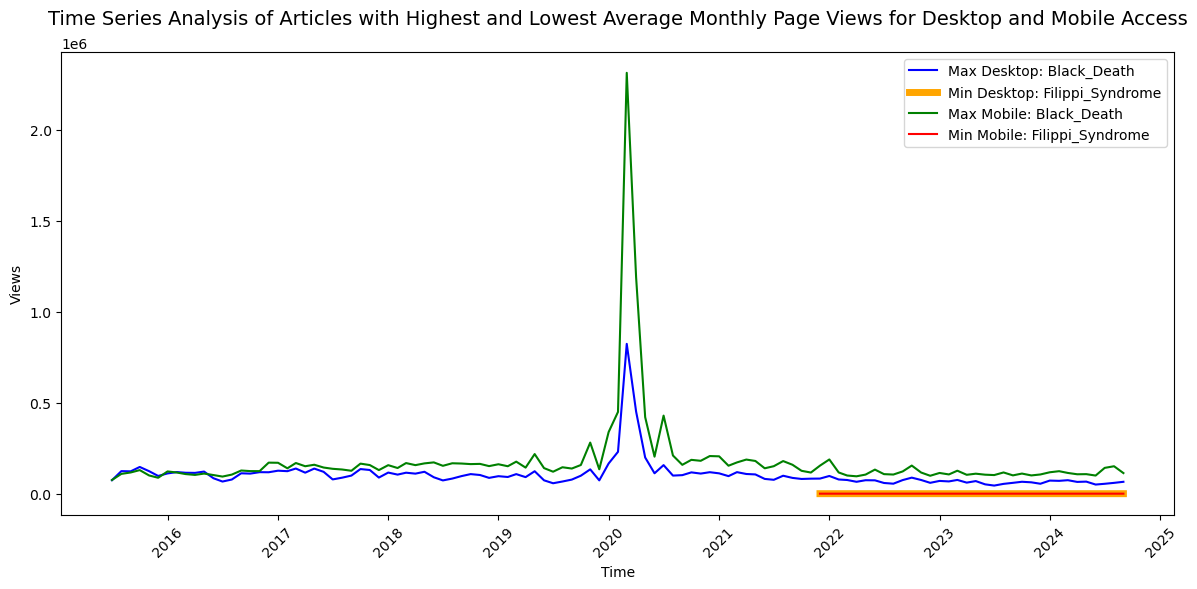

In [25]:
# Step 2a: Maximum and Minimum Averages

# Function to plot Maximum and Minimum Averages
def max_min_averages(desktop_df, mobile_df):
    # Calculate average views for desktop
    desktop_averages = desktop_df.groupby('article')['views'].mean()
    mobile_averages = mobile_df.groupby('article')['views'].mean()

    # Identify max and min articles
    max_desktop_article = desktop_averages.idxmax()
    min_desktop_article = desktop_averages.idxmin()
    max_mobile_article = mobile_averages.idxmax()
    min_mobile_article = mobile_averages.idxmin()
    print(max_desktop_article)
    print(min_desktop_article)
    print(max_mobile_article)
    print(min_mobile_article)
    

    # Prepare the data for plotting
    max_desktop_data = desktop_df[desktop_df['article'] == max_desktop_article]
    min_desktop_data = desktop_df[desktop_df['article'] == min_desktop_article]
    max_mobile_data = mobile_df[mobile_df['article'] == max_mobile_article]
    min_mobile_data = mobile_df[mobile_df['article'] == min_mobile_article]
    #print(max_desktop_data)
    print(min_desktop_data)
    #print(max_mobile_data)
    print(min_mobile_data)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot desktop data
    plt.plot(max_desktop_data['timestamp'], max_desktop_data['views'], label=f'Max Desktop: {max_desktop_article}', color='blue')
    plt.plot(min_desktop_data['timestamp'], min_desktop_data['views'], label=f'Min Desktop: {min_desktop_article}', color='orange', linewidth=5)
    
    # Plot mobile data
    plt.plot(max_mobile_data['timestamp'], max_mobile_data['views'], label=f'Max Mobile: {max_mobile_article}', color='green')
    plt.plot(min_mobile_data['timestamp'], min_mobile_data['views'], label=f'Min Mobile: {min_mobile_article}', color='red')

    # Formatting the plot
    plt.title('Time Series Analysis of Articles with Highest and Lowest Average Monthly Page Views for Desktop and Mobile Access', pad=20, fontsize=14)
    plt.xlabel('Time')
    plt.ylabel('Views')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('Maximum_and_Minimum_average_views.png')
    plt.show()

# Run the function to create the graph
max_min_averages(desktop_df, mobile_df)

### Step 2b - Data Analysis - Top 10 Peak Page Views
The second graph contains time series for the top 10 article pages by largest (peak) page views over the entire time series by access type. We first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Our graph contains the top 10 for desktop and top 10 for mobile access (20 lines).


In [26]:
# Find peak page views for each article for desktop access
peak_desktop = desktop_df.groupby('article')['views'].max().reset_index()

# Find peak page views for each article for mobile access
peak_mobile = mobile_df.groupby('article')['views'].max().reset_index()

print(peak_desktop)
print(peak_mobile)


                              article  views
0                                 18p     56
1                                18p-    352
2                      2006_in_Africa    280
3                      2007_in_Africa    247
4     2009_swine_flu_pandemic_vaccine  13773
...                               ...    ...
1765                  Zinc_deficiency  13644
1766       Zollinger–Ellison_syndrome   7544
1767                     Zona_incerta   1198
1768                       Zonisamide   3750
1769                      Zygomycosis   2313

[1770 rows x 2 columns]
                              article  views
0                                 18p     46
1                                18p-    572
2                      2006_in_Africa     84
3                      2007_in_Africa     80
4     2009_swine_flu_pandemic_vaccine  29319
...                               ...    ...
1765                  Zinc_deficiency  27968
1766       Zollinger–Ellison_syndrome  12320
1767                     Zona_

In [27]:
# Get top 10 articles by peak page views for desktop access
top_10_desktop = peak_desktop.nlargest(10, 'views')

# Get top 10 articles by peak page views for mobile access
top_10_mobile = peak_mobile.nlargest(10, 'views')
print(top_10_desktop)
print(top_10_mobile)

                                    article    views
1231                               Pandemic  1046521
193                             Black_Death   823649
299                             Chloroquine   440897
1263                      Pfeiffer_syndrome   408153
586   Fibrodysplasia_ossificans_progressiva   313785
210                                Botulism   302593
1422                            Robert_Koch   254656
1495                               Smallpox   249177
327                Cleidocranial_dysostosis   191115
91            Amyotrophic_lateral_sclerosis   186945
                       article    views
193                Black_Death  2313741
1231                  Pandemic  2276916
1263         Pfeiffer_syndrome   777886
299                Chloroquine   777537
1534     Stiff-person_syndrome   677927
1295                 Porphyria   585872
651               Glioblastoma   562173
327   Cleidocranial_dysostosis   485195
210                   Botulism   470273
870           Kaw

In [28]:
# Get time series data for top 10 desktop articles
top_10_desktop_ts = desktop_df[desktop_df['article'].isin(top_10_desktop['article'])]

# Get time series data for top 10 mobile articles
top_10_mobile_ts = mobile_df[mobile_df['article'].isin(top_10_mobile['article'])]

print(top_10_desktop_ts)
print(top_10_mobile_ts)

        timestamp  views                        article
9972   2015-07-01  73912  Amyotrophic_lateral_sclerosis
9973   2015-08-01  87726  Amyotrophic_lateral_sclerosis
9974   2015-09-01  86944  Amyotrophic_lateral_sclerosis
9975   2015-10-01  93526  Amyotrophic_lateral_sclerosis
9976   2015-11-01  72220  Amyotrophic_lateral_sclerosis
...           ...    ...                            ...
161888 2024-05-01  31418                       Smallpox
161889 2024-06-01  26179                       Smallpox
161890 2024-07-01  25670                       Smallpox
161891 2024-08-01  44500                       Smallpox
161892 2024-09-01  34675                       Smallpox

[1110 rows x 3 columns]
        timestamp   views                article
21037  2015-07-01   75236            Black_Death
21038  2015-08-01  108793            Black_Death
21039  2015-09-01  116598            Black_Death
21040  2015-10-01  129553            Black_Death
21041  2015-11-01  100144            Black_Death
...      

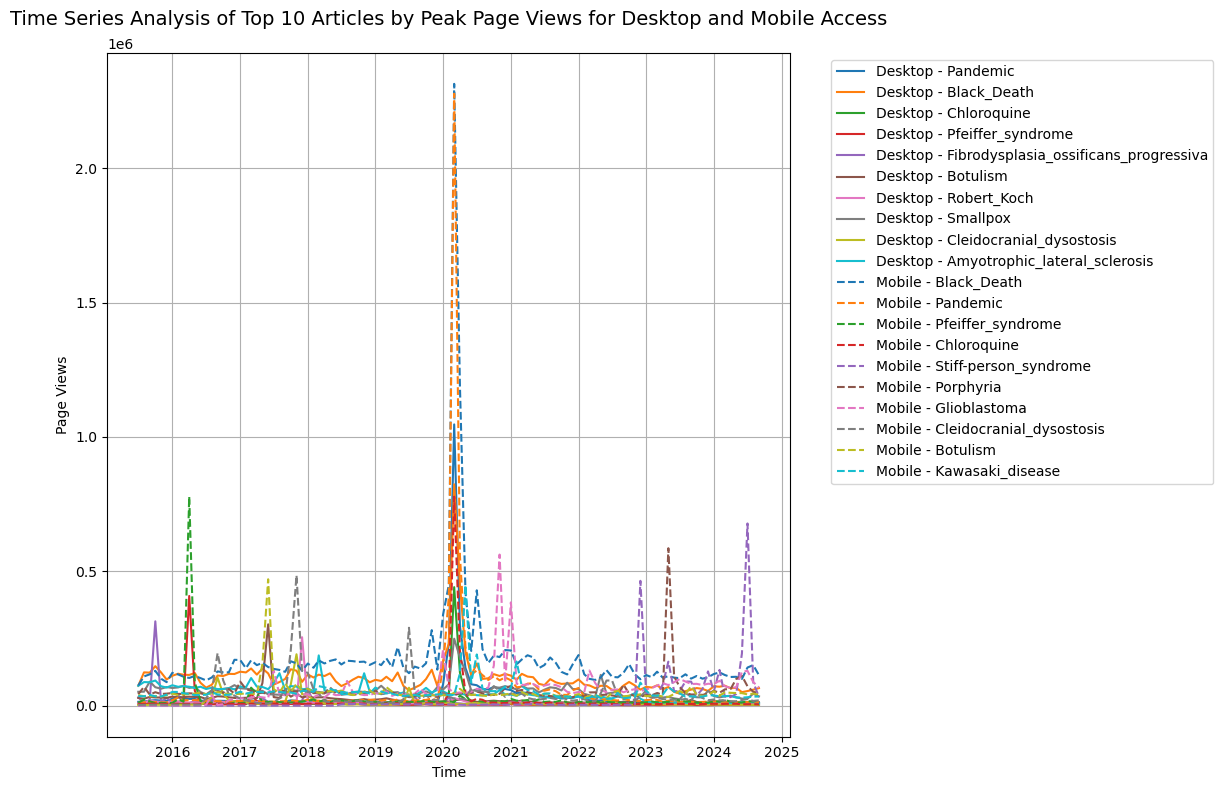

In [29]:
# Plot for desktop access
plt.figure(figsize=(12, 8))

# Plot top 10 desktop articles
for article in top_10_desktop['article']:
    article_data = top_10_desktop_ts[top_10_desktop_ts['article'] == article]
    plt.plot(article_data['timestamp'], article_data['views'], label=f"Desktop - {article}")

# Plot top 10 mobile articles
for article in top_10_mobile['article']:
    article_data = top_10_mobile_ts[top_10_mobile_ts['article'] == article]
    plt.plot(article_data['timestamp'], article_data['views'], linestyle='--', label=f"Mobile - {article}")

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Page Views')
plt.title('Time Series Analysis of Top 10 Articles by Peak Page Views for Desktop and Mobile Access', pad=20, fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show the plot
plt.tight_layout()
# Save the plot
plt.savefig('Top_10_peak_page_views.png')
plt.show()


### Step 2c - Data Analysis - Fewest Months of Data 
The third graph shows pages that have the fewest months of available data. These will be relatively short time series, some may only have one month of data. This graph shows the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.


In [30]:
# Group by article and count the number of months for desktop access
desktop_grouped = desktop_df.groupby('article').size().reset_index(name='months_count')
print("Desktop Grouped Data (Article and Months Count):")
print(desktop_grouped)

# Get the 10 articles with the fewest months of data for desktop access
desktop_least_10 = desktop_grouped.nsmallest(10, 'months_count')
print("\n10 Articles with the Fewest Months of Desktop Data:")
print(desktop_least_10)

# Group by article and count the number of months for mobile access
mobile_grouped = mobile_df.groupby('article').size().reset_index(name='months_count')
print("\nMobile Grouped Data (Article and Months Count):")
print(mobile_grouped)

# Get the 10 articles with the fewest months of data for mobile access
mobile_least_10 = mobile_grouped.nsmallest(10, 'months_count')
print("\n10 Articles with the Fewest Months of Mobile Data:")
print(mobile_least_10)


Desktop Grouped Data (Article and Months Count):
                              article  months_count
0                                 18p           111
1                                18p-           111
2                      2006_in_Africa           111
3                      2007_in_Africa           111
4     2009_swine_flu_pandemic_vaccine            54
...                               ...           ...
1765                  Zinc_deficiency           111
1766       Zollinger–Ellison_syndrome           111
1767                     Zona_incerta           111
1768                       Zonisamide           111
1769                      Zygomycosis           111

[1770 rows x 2 columns]

10 Articles with the Fewest Months of Desktop Data:
                                                article  months_count
1399  Retinal_vasculopathy_with_cerebral_leukoenceph...            33
591                                    Filippi_Syndrome            34
240       COVID-19_vaccine_misinformati

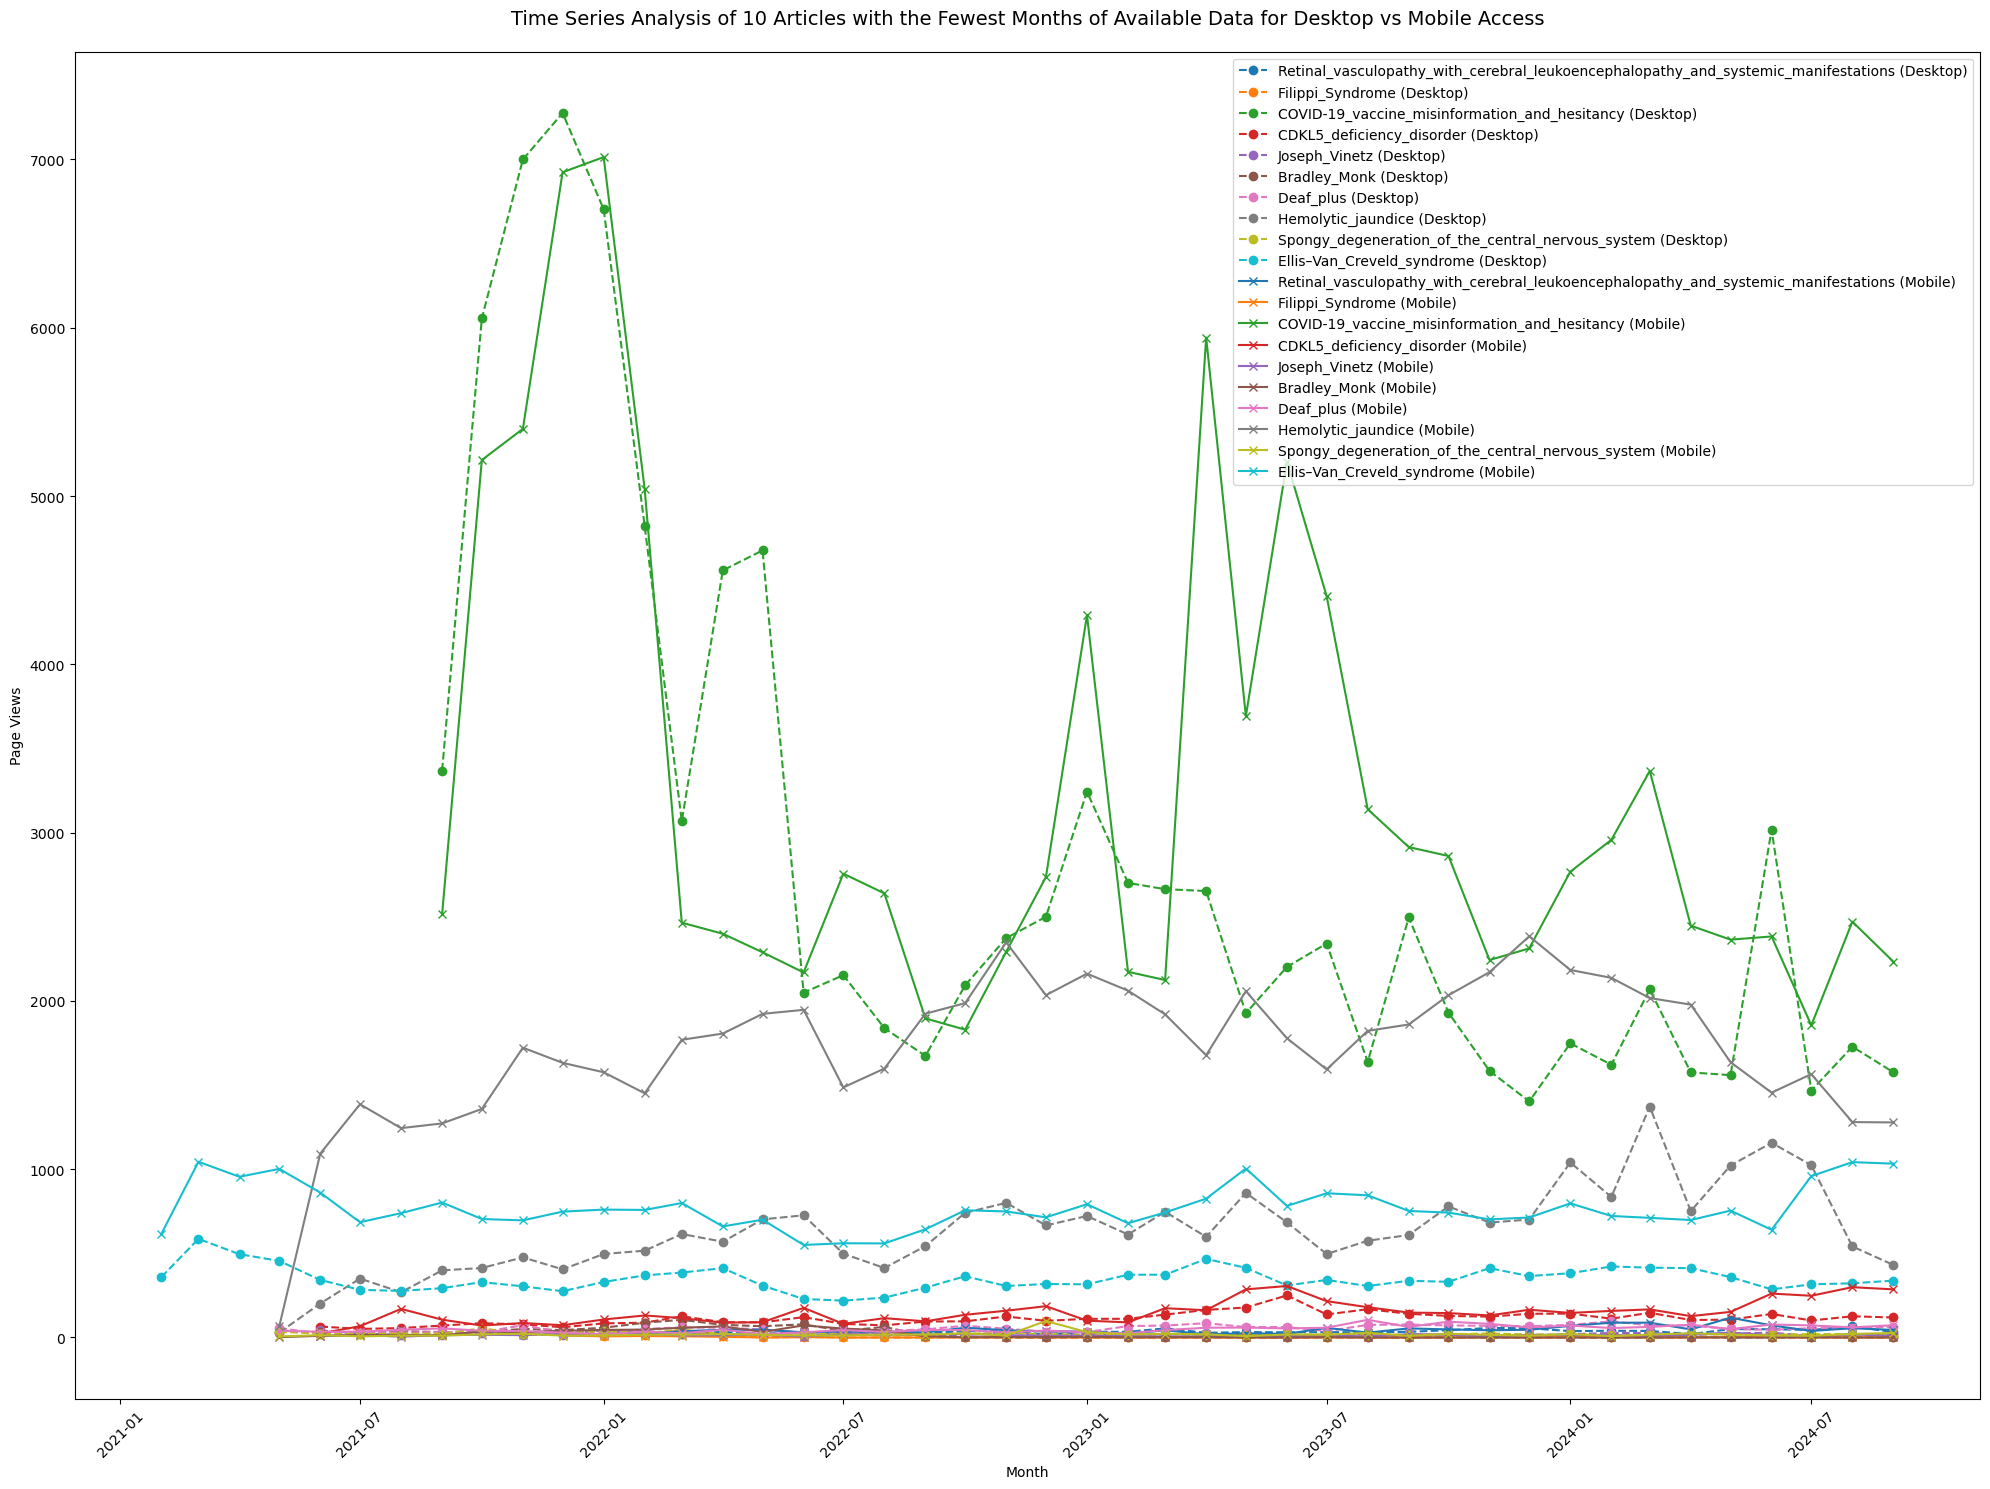

In [33]:
# Set up the plot
fig, ax = plt.subplots(figsize=(20, 15))

# Plotting the desktop data for the 10 articles with the fewest months of data
for article in desktop_least_10['article']:
    subset = desktop_df[desktop_df['article'] == article]
    ax.plot(subset['timestamp'], subset['views'], label=f"{article} (Desktop)", linestyle='--', marker='o')

# Plotting the mobile data for the 10 articles with the fewest months of data
for article in mobile_least_10['article']:
    subset = mobile_df[mobile_df['article'] == article]
    ax.plot(subset['timestamp'], subset['views'], label=f"{article} (Mobile)", linestyle='-', marker='x')

# Set titles and labels
ax.set_title('Time Series Analysis of 10 Articles with the Fewest Months of Available Data for Desktop vs Mobile Access', pad=20, fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Page Views')

# Rotate the x-ticks for better readability
ax.tick_params(axis='x', rotation=45)

# Add a legend to differentiate desktop and mobile lines
ax.legend(loc='upper right')

# Save the figure as a PNG file
plt.tight_layout()
plt.savefig('Fewest_months_of_data_combined.png', format='png')

# Show the plot
plt.show()

### Step 3 - Conclusion

In conclusion, three graphs were built from the monthly article traffic data for articles about rare diseases from English Wikipedia from July 1, 2015, through September 30, 2024. These graphs reveal trends and patterns present in the pageviews data. The first graph explored the time series relationship for articles with the highest and lowest average monthly page requests for both desktop and mobile access. It was found that articles on "Black_Death" had the highest average monthly views for desktop as well as mobile. Conversely, articles like "Filippi_Syndrome" had the lowest average monthly views for both desktop and mobile.

The second graph displayed time series data for the top 10 articles by largest page views over the entire period by access type, showing that peaks for mobile views were generally higher than for desktop. These peaks were clustered into a few distinct time periods.

Lastly, the third graph showcased articles with the fewest months of available data across desktop and mobile access types. These short time series represented diseases with less public attention, with relatively few pageview records. It was observed that the trends for both desktop and mobile views followed similar patterns across most articles.